In [1]:
import os
import datetime
import threading
import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt

# %matplotlib notebook

In [8]:
########################
##    Reading data    ##
########################

data = pd.read_pickle('filtered_data.pkl')
print('data :', data.shape)
data.head()

data : (1533686, 5)


,STATE,EVENT_TYPE,BEGIN_YEARMONTH,DATE,DIST_FROM_START
0,OKLAHOMA,Tornado,195004,1950-04-06,84
1,TEXAS,Tornado,195004,1950-04-01,79
2,PENNSYLVANIA,Tornado,195007,1950-07-21,190
3,PENNSYLVANIA,Tornado,195007,1950-07-25,194
4,PENNSYLVANIA,Tornado,195007,1950-07-19,188


# Problem
<br>
Most of the events have info only since ~ 2005 and if our data starts from 1950 this is a big problem ! 

So there are two ways to go:
<hr>
1. To train the model on the event types that have information for all the years.
<hr>
2. To train the model on the data since 2005, so that we have constand information for most of the events.
<hr>
<br> 
If we do the first way, we will only have 3 event types but a lot of data about them (since 1950).

This is not exactly what we want, so we should train the model only on the data since 2005. 
<hr>
Below I represent the plots for the event type count alonge the timeline, from 1950 to 2018 (both with bars and with line plot ;) )
<br> <br>

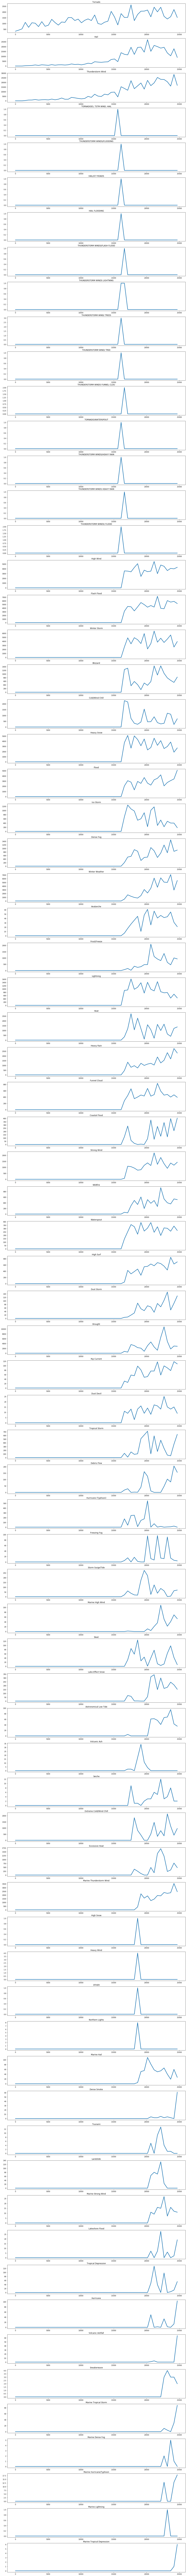

In [11]:
####################
##   Line plots   ##
####################

event_types = data.EVENT_TYPE.unique()
fig = plt.figure(figsize=(20, 4*len(event_types)))
ax = fig.subplots(len(event_types))
year_range = (data.DIST_FROM_START.min(), data.DIST_FROM_START.max())
for i, event_type in enumerate(event_types):
    hist = np.histogram(data[data.EVENT_TYPE==event_type].DIST_FROM_START,bins=50,range=year_range)
    ax[i].set_title(event_type)
    ax[i].plot(hist[1][:-1], hist[0], linewidth=3)
plt.show()

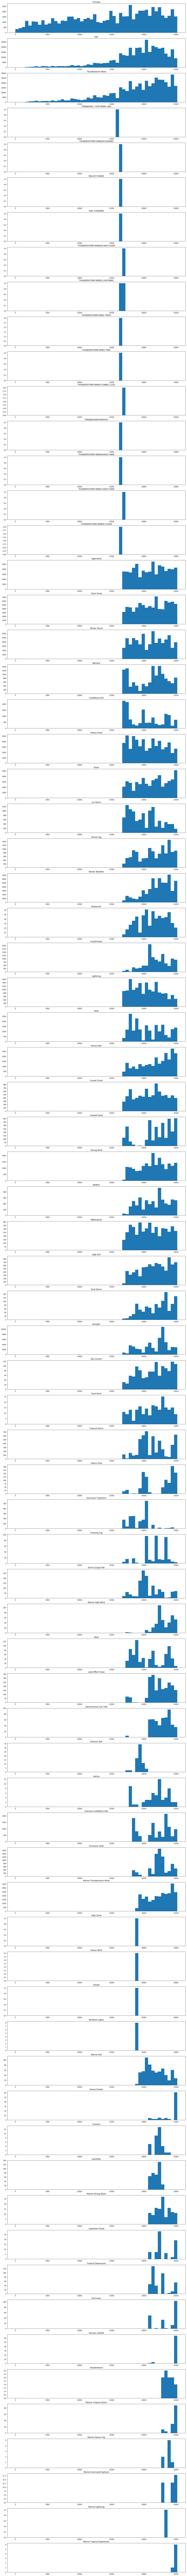

In [12]:
##################
#   Bar plots   ##
##################

event_types = data.EVENT_TYPE.unique()
fig = plt.figure(figsize=(20, 4*len(event_types)))
ax = fig.subplots(len(event_types))
year_range = (data.DIST_FROM_START.min(), data.DIST_FROM_START.max())
for i, event_type in enumerate(event_types):
    ax[i].set_title(event_type)
    ax[i].hist(data[data.EVENT_TYPE==event_type].DIST_FROM_START,bins=50,range=year_range)
plt.show()

# Conclusion
<br>
We will have to remove some event types anyway (based on the counts and distributions). 

These are the ones we retain:
<hr>
    
    Event type                      Count

    Astronomical Low Tide           532
    Avalanche                       613
    Blizzard                        13156
    Coastal Flood                   2897
    Cold/Wind Chill                 13687
    Debris Flow                     978
    Dense Fog                       12669
    Dense Smoke                     82
    Drought                         54597
    Dust Devil                      219
    Dust Storm                      1088
    Excessive Heat                  7464
    Extreme Cold/Wind Chill         11157
    Flash Flood                     81019
    Flood                           50708
    Freezing Fog                    390
    Frost/Freeze                    11392
    Funnel Cloud                    8262
    Hail                            358952
    Heat                            19698
    Heavy Rain                      23757
    Heavy Snow                      59306
    High Surf                       8734
    High Wind                       66371
    Hurricane                       202
    Hurricane (Typhoon)             1714
    Ice Storm                       10949
    Lake-Effect Snow                2249
    Lakeshore Flood                 69
    Landslide                       372
    Lightning                       16332
    Marine Hail                     677
    Marine High Wind                420
    Marine Hurricane/Typhoon        44
    Marine Strong Wind              124
    Marine Thunderstorm Wind        25407
    Marine Tropical Storm           133
    Rip Current                     1267
    Seiche                          61
    Sleet                           725
    Storm Surge/Tide                1301
    Strong Wind                     19831
    Thunderstorm Wind               430085
    Tornado                         69129
    Tropical Depression             383
    Tropical Storm                  5002
    Tsunami                         33
    Volcanic Ash                    70
    Volcanic Ashfall                69
    Waterspout                      4891
    Wildfire                        6959
    Winter Storm                    70505
    Winter Weather                  56892
<hr>

<br> <br>

In [15]:
###################################
##   Selecting the event types   ##
###################################

selected_data = pd.concat([
    data[data.EVENT_TYPE=='Astronomical Low Tide'],
    data[data.EVENT_TYPE=='Avalanche'],
    data[data.EVENT_TYPE=='Blizzard'],
    data[data.EVENT_TYPE=='Coastal Flood'],
    data[data.EVENT_TYPE=='Cold/Wind Chill'],
    data[data.EVENT_TYPE=='Debris Flow'],
    data[data.EVENT_TYPE=='Dense Fog'],
    data[data.EVENT_TYPE=='Dense Smoke'],
    data[data.EVENT_TYPE=='Drought'],
    data[data.EVENT_TYPE=='Dust Devil'],
    data[data.EVENT_TYPE=='Dust Storm'],
    data[data.EVENT_TYPE=='Excessive Heat'],
    data[data.EVENT_TYPE=='Extreme Cold/Wind Chill'],
    data[data.EVENT_TYPE=='Flash Flood'],
    data[data.EVENT_TYPE=='Flood'],
    data[data.EVENT_TYPE=='Freezing Fog'],
    data[data.EVENT_TYPE=='Frost/Freeze'],
    data[data.EVENT_TYPE=='Funnel Cloud'],
    data[data.EVENT_TYPE=='Hail'],
    data[data.EVENT_TYPE=='Heat'],
    data[data.EVENT_TYPE=='Heavy Rain'],
    data[data.EVENT_TYPE=='Heavy Snow'],
    data[data.EVENT_TYPE=='High Surf'],
    data[data.EVENT_TYPE=='High Wind'],
    data[data.EVENT_TYPE=='Hurricane'],
    data[data.EVENT_TYPE=='Hurricane (Typhoon)'],
    data[data.EVENT_TYPE=='Ice Storm'],
    data[data.EVENT_TYPE=='Lake-Effect Snow'],
    data[data.EVENT_TYPE=='Lakeshore Flood'],
    data[data.EVENT_TYPE=='Landslide'],
    data[data.EVENT_TYPE=='Lightning'],
    data[data.EVENT_TYPE=='Marine Hail'],
    data[data.EVENT_TYPE=='Marine High Wind'],
    data[data.EVENT_TYPE=='Marine Hurricane/Typhoon'],
    data[data.EVENT_TYPE=='Marine Strong Wind'],
    data[data.EVENT_TYPE=='Marine Thunderstorm Wind'],
    data[data.EVENT_TYPE=='Marine Tropical Storm'],
    data[data.EVENT_TYPE=='Rip Current'],
    data[data.EVENT_TYPE=='Seiche'],
    data[data.EVENT_TYPE=='Sleet'],
    data[data.EVENT_TYPE=='Storm Surge/Tide'],
    data[data.EVENT_TYPE=='Strong Wind'],
    data[data.EVENT_TYPE=='Thunderstorm Wind'],
    data[data.EVENT_TYPE=='Tornado'],
    data[data.EVENT_TYPE=='Tropical Depression'],
    data[data.EVENT_TYPE=='Tropical Storm'],
    data[data.EVENT_TYPE=='Tsunami'],
    data[data.EVENT_TYPE=='Volcanic Ash'],
    data[data.EVENT_TYPE=='Volcanic Ashfall'],
    data[data.EVENT_TYPE=='Waterspout'],
    data[data.EVENT_TYPE=='Wildfire'],
    data[data.EVENT_TYPE=='Winter Storm'],
    data[data.EVENT_TYPE=='Winter Weather']
])

print('data           :', data.shape)
print('selected_data  :', selected_data.shape)

data           : (1533686, 5)
selected_data  : (1533623, 5)


In [15]:
########################################################
##   We now pick only the events starting form 1996   ##
##          It is the start of the majority           ##
########################################################

threshold = datetime.date(1996, 1, 1)

print('Before  :', selected_data.shape)
selected_data = selected_data[selected_data.DATE>=threshold]
print('After   :', selected_data.shape)

Before  : (1533623, 5)
After   : (1301399, 5)


In [21]:
##############################
##   Saving selected data   ##
##############################

selected_data.to_pickle('selected_data.pkl')